## ToDo
- 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random
# import graphviz
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sympy import *
from IPython.display import display, Math
import os
pd.set_option('display.max_columns', None)
from datetime import datetime
import json
import time
import glob

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'exp': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}


def calc_weights(binary_labels):
    """Returns weights to produce 50-50 class weighting
    """
    n_pos = np.sum(binary_labels)
    n_neg = len(binary_labels) - n_pos
    weights = [1 if label==1 else n_pos/n_neg for label in binary_labels]
    return weights


def vis_expr(classifier, save_prefix):
    """Function for prettifying expressions output by the symbolic classifier
    Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas
    """
    expression = latex(sympify((str(classifier._program)), locals=converter))
    fig, ax = plt.subplots(figsize=(0.1,0.1))
    ax.set_xticks([]); ax.set_yticks([])
    ax.axis('off')
    plt.text(0, 0,'$%s$'%expression, size=15)
    plt.savefig(f'{save_prefix}_expression.png', dpi=300, bbox_inches='tight')
    plt.show()


def save_results(search, save_prefix):
    # Save formula of best estimator
    classifier = search.best_estimator_
    formula = str(classifier._program)
    with open(f'{save_prefix}_formula.txt', 'a+') as f:
        f.write(formula)
    # Save params of best estimator
    params = classifier.get_params()
    params['feature_names'] = list(params['feature_names'])
    params['function_set'] = list(params['function_set'])
    with open(f'{save_prefix}_params.json', 'a+') as f:
        json.dump(params, f)
    # Save hyperparam opt results  
    pd.DataFrame(search.cv_results_).to_json(f'{save_prefix}_cvresults.json')      

        
def plot_run(classifier):
    run_details = classifier.run_details_
    fig, ax1 = plt.subplots(figsize=(6,2))
    skip_gen = 1
    colors = ['tab:red', 'tab:blue']
    ax1.set_ylabel('average_length', color=colors[0])
    ax1.plot(run_details['generation'][skip_gen:], run_details['average_length'][skip_gen:], 
             label='Avg Length', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
#     ax1.set_ylim(0,10)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('average_fitness', color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(run_details['generation'][skip_gen:], run_details['average_fitness'][skip_gen:], 
             label='Avg Length', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
#     ax2.set_ylim(0,2.5)
    ax1.set_xlabel('Generation')
    plt.xlim(0,None)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    
def examine_search(search, features_test, labels_test):
    
    classifier = search.best_estimator_
    
    ### Plot run history
    plot_run(classifier)

    ### Evaluate on test set
    predictions = classifier.predict(features_test)
    precision = int(100*precision_score(labels_test, predictions))
    recall = int(100*recall_score(labels_test, predictions))
    roc_auc = int(100*roc_auc_score(labels_test,predictions)) 
    print(f'AUC:    \t{roc_auc}\nPrecision: \t{precision}\nRecall: \t{recall}')

    ### Evaluate on the rest of the negative class set
    # Getting the rest of the negative set features and values
    remainder_negative_set_idx = negative_scrambled_order[n_positive_class:]
    remainder_negative_features = neg_features[remainder_negative_set_idx,:]
    remainder_negative_labels = neg_labels[remainder_negative_set_idx]
    acc_neg = int(100*np.mean(remainder_negative_labels == classifier.predict(remainder_negative_features)))
    print(f'Acc (-):    \t{acc_neg}')

    ### Visualize expression, record run
    dt_string = datetime.now().strftime("%Y%m%d_%H%M")
    save_prefix = f'models/c{pos_label}vsall_{label2proto[pos_label]}_auc{roc_auc}_prec{precision}_reca{recall}_accn{acc_neg}_len{classifier._program.length_}_{dt_string}'
    vis_expr(classifier, save_prefix)
    save_results(search, save_prefix)
    

def reduce_feat_by_corr(feat_df, thresh=0.95):
    """
    Returns a copy of the input dataframe with correlated 
    features removed (defined as correlation > thresh)

    Parameters:
    feat_df (pandas.DataFrame): Dataframe containing the features
    thresh (float): Correlation threshold value

    Returns:
    pandas.DataFrame: A copy of the input dataframe with pruned features
    """
    feats_to_prune = set([])
    immune = set([])
    corr = feat_df.corr()
    for feat in feat_df.columns:
        # If we already pruned this feature, we're done here
        if feat in feats_to_prune: continue
        # If not, make it immune and discard things correlated with it
        immune.update({feat})
        correlated_features = set(corr[corr[feat] > thresh].index)
        feats_to_prune.update(correlated_features - immune)
    return feat_df.drop(columns=feats_to_prune).copy()


def calc_feature_importances(feat_df, label_df, seed, n_splits=5):
    
    ### Store results
    cv_precisions = []
    cv_recalls = []
    aggregated_feature_importances = []
    
    features = feat_df.to_numpy()
    labels = label_df.label_binary.to_numpy()
    
    ### K-fold CV
    skf = StratifiedKFold(n_splits=n_splits)
    for i, (train_idx, test_idx) in enumerate(skf.split(feat_df,label_df.label_binary)):
        feat_df_train = feat_df.iloc[train_idx]
        feat_df_test =  feat_df.iloc[test_idx]
        label_df_train = label_df.iloc[train_idx]
        label_df_test =  label_df.iloc[test_idx]
        # Fit, eval naive rf model
        clf = RandomForestClassifier(n_estimators=25, class_weight='balanced', criterion='log_loss', 
                                     random_state=seed, ccp_alpha=0.001, oob_score=True)
        clf.fit(feat_df_train.to_numpy(), 
                label_df_train.label_binary.to_numpy())
        predict_labels = clf.predict(feat_df_test.to_numpy())
        precision = precision_score(label_df_test.label_binary.to_numpy(), predict_labels)
        recall = recall_score(label_df_test.label_binary.to_numpy(), predict_labels)
        # Record results
        aggregated_feature_importances.append(clf.feature_importances_)
        cv_precisions.append(precision)
        cv_recalls.append(recall)
        # print(f'Mean depth:      {np.mean([estimator.get_depth() for estimator in clf.estimators_])}')
        # print(f'Mean node count: {np.mean([estimator.tree_.node_count for estimator in clf.estimators_])}')
        # print(f'OOB score:       {clf.oob_score_}')
    return np.mean(aggregated_feature_importances, axis=0), np.mean(cv_precisions), np.mean(cv_recalls)


def reduce_feat_by_RFimport(feat_df, label_df, seed, n_features=5, keep_frac=0.75):
    feature_names = list(feat_df.columns)
    nfeats, precs, recalls = [], [], []
    
    while True:
        ### Calculate importances
        importances, prec, recall = calc_feature_importances(feat_df[feature_names], label_df, seed)
        
        ### Record results
        nfeats.append(len(importances))
        precs.append(prec)
        recalls.append(recall)
        
        ### Terminal case: cut to n_features, evaluate one more time
        if len(importances) < np.ceil(n_features/keep_frac):
            feature_names = feature_names[:n_features]
            importances, prec, recall = calc_feature_importances(feat_df, label_df, seed)
            nfeats.append(len(importances))
            precs.append(prec)
            recalls.append(recall)
            return feature_names[:n_features], nfeats, precs, recalls
        
        ### Iterative case: keep top keep_frac of features, discard the rest
        _, feature_names = zip(*sorted(zip(importances, feature_names), reverse=True))
        feature_names = list(feature_names)
        feature_names = feature_names[:int(np.ceil(keep_frac*len(feature_names)))]
        print(f'{len(importances)} features left')


def prep_labels(label_df):
    ### Prepare labels
    # Find unique labels and counts
    class_df = pd.DataFrame(label_df.value_counts()).reset_index()
    class_df = class_df.rename(columns={0:'population'})
    class_df['label'] = class_df.index
    # display(class_df.head())
    # Convert to numerical labels
    proto2label = {proto:label for proto,label in class_df[['Prototype','label']].to_numpy()}
    label2proto = {label:proto for proto,label in class_df[['Prototype','label']].to_numpy()}
    label_df['label'] = [proto2label[proto] for proto in label_df.Prototype]
    # label_df.head()
    # print(labels_1vsall)
    return label_df, class_df, proto2label, label2proto

# Import Data

In [2]:
### CONSTANTS ###########################################################
label_path = '../3_generate_features/final_label_array.csv'
feat_path = '../3_generate_features/dimensionless_cropped_final_feature_array.csv'
feat_reduction_path = 'feature_reduction/features_c1/13_iteration_feature_9_features.csv'
# pos_label = 1 
#########################################################################

label_df = pd.read_csv(label_path).drop(columns='Unnamed: 0',errors='ignore')
feat_df = pd.read_csv(feat_path).drop(columns='Unnamed: 0',errors='ignore')

# Preprocess Data

In [5]:
### Prep, find most populous prototypes
label_df, class_df, proto2label, label2_proto = prep_labels(label_df)
display(class_df.head())

### Initial feature reduction
feat_df = reduce_feat_by_corr(feat_df)
display(feat_df.head())

,Prototype,label,population
0,Laves(cub)#MgCu2,0,1532
1,Fluorite#CaF2,1,507
2,Laves(2H)#MgZn2,2,475
3,Rutile#TiO2,3,467
4,AlB2,4,368


,e1_avg_oxi_pos/e1_avg_oxi_neg,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_neg)/e1_avg_oxi_pos,e1_avg_oxi_neg/e2_avg_oxi_pos,(e1_avg_oxi_neg+e2_avg_oxi_pos)/e1_avg_oxi_neg,e1_MendeleevNumber/e2_MendeleevNumber,(e1_MendeleevNumber+e2_MendeleevNumber)/e1_MendeleevNumber,(e1_MendeleevNumber-e2_MendeleevNumber)/e1_MendeleevNumber,e1_Column/e1_Row,(e1_Column+e1_Row)/e1_Column,(e1_Column-e1_Row)/e1_Column,e1_Column/e2_Column,(e1_Column+e2_Column)/e1_Column,(e1_Column-e2_Column)/e1_Column,e1_Column/e2_Row,(e1_Column+e2_Row)/e1_Column,(e1_Column-e2_Row)/e1_Column,e1_Row/e2_Column,(e1_Row+e2_Column)/e1_Row,(e1_Row-e2_Column)/e1_Row,e1_Row/e2_Row,(e1_Row+e2_Row)/e1_Row,(e1_Row-e2_Row)/e1_Row,e2_Column/e2_Row,(e2_Column+e2_Row)/e2_Column,(e2_Column-e2_Row)/e2_Column,e1_AtomicWeight/e2_AtomicWeight,(e1_AtomicWeight+e2_AtomicWeight)/e1_AtomicWeight,(e1_AtomicWeight-e2_AtomicWeight)/e1_AtomicWeight,e1_MeltingT/e2_MeltingT,(e1_MeltingT+e2_MeltingT)/e1_MeltingT,(e1_MeltingT-e2_MeltingT)/e1_MeltingT,e1_CovalentRadius/e2_CovalentRadius,(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius,(e1_CovalentRadius-e2_CovalentRadius)/e1_CovalentRadius,e1_NsValence/e1_NpValence,(e1_NsValence+e1_NpValence)/e1_NsValence,(e1_NsValence-e1_NpValence)/e1_NsValence,e1_NsValence/e1_NdValence,(e1_NsValence+e1_NdValence)/e1_NsValence,(e1_NsValence-e1_NdValence)/e1_NsValence,e1_NsValence/e1_NfValence,(e1_NsValence+e1_NfValence)/e1_NsValence,(e1_NsValence-e1_NfValence)/e1_NsValence,e1_NsValence/e1_NValence,(e1_NsValence+e1_NValence)/e1_NsValence,(e1_NsValence-e1_NValence)/e1_NsValence,e1_NsValence/e1_NsUnfilled,(e1_NsValence+e1_NsUnfilled)/e1_NsValence,(e1_NsValence+e1_NpUnfilled)/e1_NsValence,(e1_NsValence-e1_NpUnfilled)/e1_NsValence,e1_NsValence/e1_NdUnfilled,(e1_NsValence+e1_NdUnfilled)/e1_NsValence,(e1_NsValence-e1_NdUnfilled)/e1_NsValence,e1_NsValence/e1_NfUnfilled,(e1_NsValence+e1_NfUnfilled)/e1_NsValence,(e1_NsValence-e1_NfUnfilled)/e1_NsValence,e1_NsValence/e1_NUnfilled,(e1_NsValence+e1_NUnfilled)/e1_NsValence,(e1_NsValence-e1_NUnfilled)/e1_NsValence,e1_NsValence/e2_NsValence,(e1_NsValence+e2_NsValence)/e1_NsValence,(e1_NsValence-e2_NsValence)/e1_NsValence,e1_NsValence/e2_NpValence,(e1_NsValence+e2_NpValence)/e1_NsValence,(e1_NsValence-e2_NpValence)/e1_NsValence,e1_NsValence/e2_NdValence,(e1_NsValence+e2_NdValence)/e1_NsValence,(e1_NsValence-e2_NdValence)/e1_NsValence,e1_NsValence/e2_NfValence,(e1_NsValence+e2_NfValence)/e1_NsValence,(e1_NsValence-e2_NfValence)/e1_NsValence,e1_NsValence/e2_NValence,(e1_NsValence+e2_NValence)/e1_NsValence,(e1_NsValence-e2_NValence)/e1_NsValence,e1_NsValence/e2_NsUnfilled,(e1_NsValence+e2_NsUnfilled)/e1_NsValence,e1_NsValence/e2_NpUnfilled,(e1_NsValence+e2_NpUnfilled)/e1_NsValence,(e1_NsValence-e2_NpUnfilled)/e1_NsValence,e1_NsValence/e2_NdUnfilled,(e1_NsValence+e2_NdUnfilled)/e1_NsValence,(e1_NsValence-e2_NdUnfilled)/e1_NsValence,e1_NsValence/e2_NfUnfilled,(e1_NsValence+e2_NfUnfilled)/e1_NsValence,(e1_NsValence-e2_NfUnfilled)/e1_NsValence,e1_NsValence/e2_NUnfilled,(e1_NsValence+e2_NUnfilled)/e1_NsValence,(e1_NsValence-e2_NUnfilled)/e1_NsValence,e1_NpValence/e1_NdValence,(e1_NpValence+e1_NdValence)/e1_NpValence,(e1_NpValence-e1_NdValence)/e1_NpValence,e1_NpValence/e1_NfValence,e1_NpValence/e1_NValence,(e1_NpValence+e1_NValence)/e1_NpValence,(e1_NpValence-e1_NValence)/e1_NpValence,e1_NpValence/e1_NsUnfilled,(e1_NpValence+e1_NsUnfilled)/e1_NpValence,(e1_NpValence-e1_NsUnfilled)/e1_NpValence,e1_NpValence/e1_NpUnfilled,(e1_NpValence+e1_NpUnfilled)/e1_NpValence,(e1_NpValence-e1_NpUnfilled)/e1_NpValence,e1_NpValence/e1_NdUnfilled,e1_NpValence/e1_NfUnfilled,e1_NpValence/e1_NUnfilled,e1_NpValence/e2_NsValence,(e1_NpValence+e2_NsValence)/e1_NpValence,(e1_NpValence-e2_NsValence)/e1_NpValence,e1_NpValence/e2_NpValence,(e1_NpValence+e2_NpValence)/e1_NpValence,(e1_NpValence-e2_NpValence)/e1_NpValence,e1_NpValence/e2_NdValence,(e1_NpValence+e2_NdValence)/e1_NpVa

In [133]:
### Loop through 20 most populous classes

    ### Train, test, save

0       0.056394
1       0.056394
2       1.000000
3       0.056394
4       0.056394
          ...   
8743    0.056394
8744    0.056394
8745    0.056394
8746    1.000000
8747    0.056394
Name: weight, Length: 8748, dtype: float64

In [9]:
def train_test_save(feat_df, label_df, select_prototype, seed=0, n_splits=5):
    
    ### Convert to binary (1 vs rest), where 1 => select_prototype
    label_df['label_binary'] = (label_df.Prototype == select_prototype).astype(int)
    
    ### Calculate weights label_weights
    label_df['weight'] = calc_weights(label_df.label_binary)
    
    ### Train-test split
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) 
    for i, (train_idx, test_idx) in enumerate(skf.split(feat_df, label_df.label_binary)):
        feat_df_train = feat_df.iloc[train_idx]#.copy()
        feat_df_test =  feat_df.iloc[test_idx]#.copy()
        label_df_train = label_df.iloc[train_idx]#.copy()
        label_df_test =  label_df.iloc[test_idx]#.copy()
        print(f"Fold {i}:")
    
        ### RF Feature reduction
        feature_to_keep, n, precs, recs = reduce_feat_by_RFimport(feat_df, label_df, 0)
        this_feat_df = feat_df[feature_to_keep]
        print(f'Feature set: {list(this_feat_df.columns)}')
        
        ### Train, eval model
        param_distros = {'population_size': scipy.stats.randint(500,2000),
                         'tournament_size': scipy.stats.randint(10,50),
                         'generations': scipy.stats.randint(10,50),
        #                  'parsimony_coefficient': scipy.stats.uniform(0.01, 0.001)
                     }
        
        base_estimator = SymbolicClassifier(init_depth=(1,5),
                                            parsimony_coefficient=0.005,
                                            generations=25,
                                            p_crossover = 0.85,
                                            p_subtree_mutation = 0.01,
                                            p_point_mutation = 0.01,
                                            p_hoist_mutation = 0.1,
                                            const_range=(-10,10),
                                            feature_names=feature_names,
                                            # verbose=1,
                                            n_jobs=-1, 
                                            random_state=0,
                                            function_set={'add','sub','mul','div','max','min'}
                                            )

        start = time.time()
        sh = HalvingRandomSearchCV(base_estimator, param_distros, cv=5,
                                   min_resources=20, max_resources=80, factor=2
                                  ).fit(feat_df_train.to_numpy(), label_df_train.label_binary.to_numpy())
        print(f'Time elapsed: {(time.time()-start)/3600}h')
        examine_model(sh.best_estimator_)
        
        ### Evaluate model

        ### Save model
    
    return feat_df

train_test_save(feat_df, label_df, 'Rutile#TiO2')

Fold 0:
509 features left
382 features left
287 features left
216 features left
162 features left
122 features left
92 features left
69 features left
52 features left
39 features left
30 features left
23 features left
18 features left
14 features left
11 features left
9 features left
7 features left
Index(['e1_MeltingT/e2_MeltingT', '(e1_MeltingT+e2_MeltingT)/e1_MeltingT',
       '(e1_MeltingT-e2_MeltingT)/e1_MeltingT',
       'e1_CovalentRadius/e2_CovalentRadius', '(e2_Column-e2_Row)/e2_Column'],
      dtype='object')
Fold 1:
509 features left
382 features left
287 features left
216 features left
162 features left
122 features left
92 features left
69 features left
52 features left
39 features left
30 features left
23 features left
18 features left
14 features left
11 features left
9 features left
7 features left
Index(['e1_MeltingT/e2_MeltingT', '(e1_MeltingT+e2_MeltingT)/e1_MeltingT',
       '(e1_MeltingT-e2_MeltingT)/e1_MeltingT',
       'e1_CovalentRadius/e2_CovalentRadius', '(e2_

,e1_avg_oxi_pos/e1_avg_oxi_neg,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_neg)/e1_avg_oxi_pos,e1_avg_oxi_neg/e2_avg_oxi_pos,(e1_avg_oxi_neg+e2_avg_oxi_pos)/e1_avg_oxi_neg,e1_MendeleevNumber/e2_MendeleevNumber,(e1_MendeleevNumber+e2_MendeleevNumber)/e1_MendeleevNumber,(e1_MendeleevNumber-e2_MendeleevNumber)/e1_MendeleevNumber,e1_Column/e1_Row,(e1_Column+e1_Row)/e1_Column,(e1_Column-e1_Row)/e1_Column,e1_Column/e2_Column,(e1_Column+e2_Column)/e1_Column,(e1_Column-e2_Column)/e1_Column,e1_Column/e2_Row,(e1_Column+e2_Row)/e1_Column,(e1_Column-e2_Row)/e1_Column,e1_Row/e2_Column,(e1_Row+e2_Column)/e1_Row,(e1_Row-e2_Column)/e1_Row,e1_Row/e2_Row,(e1_Row+e2_Row)/e1_Row,(e1_Row-e2_Row)/e1_Row,e2_Column/e2_Row,(e2_Column+e2_Row)/e2_Column,(e2_Column-e2_Row)/e2_Column,e1_AtomicWeight/e2_AtomicWeight,(e1_AtomicWeight+e2_AtomicWeight)/e1_AtomicWeight,(e1_AtomicWeight-e2_AtomicWeight)/e1_AtomicWeight,e1_MeltingT/e2_MeltingT,(e1_MeltingT+e2_MeltingT)/e1_MeltingT,(e1_MeltingT-e2_MeltingT)/e1_MeltingT,e1_CovalentRadius/e2_CovalentRadius,(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius,(e1_CovalentRadius-e2_CovalentRadius)/e1_CovalentRadius,e1_NsValence/e1_NpValence,(e1_NsValence+e1_NpValence)/e1_NsValence,(e1_NsValence-e1_NpValence)/e1_NsValence,e1_NsValence/e1_NdValence,(e1_NsValence+e1_NdValence)/e1_NsValence,(e1_NsValence-e1_NdValence)/e1_NsValence,e1_NsValence/e1_NfValence,(e1_NsValence+e1_NfValence)/e1_NsValence,(e1_NsValence-e1_NfValence)/e1_NsValence,e1_NsValence/e1_NValence,(e1_NsValence+e1_NValence)/e1_NsValence,(e1_NsValence-e1_NValence)/e1_NsValence,e1_NsValence/e1_NsUnfilled,(e1_NsValence+e1_NsUnfilled)/e1_NsValence,(e1_NsValence+e1_NpUnfilled)/e1_NsValence,(e1_NsValence-e1_NpUnfilled)/e1_NsValence,e1_NsValence/e1_NdUnfilled,(e1_NsValence+e1_NdUnfilled)/e1_NsValence,(e1_NsValence-e1_NdUnfilled)/e1_NsValence,e1_NsValence/e1_NfUnfilled,(e1_NsValence+e1_NfUnfilled)/e1_NsValence,(e1_NsValence-e1_NfUnfilled)/e1_NsValence,e1_NsValence/e1_NUnfilled,(e1_NsValence+e1_NUnfilled)/e1_NsValence,(e1_NsValence-e1_NUnfilled)/e1_NsValence,e1_NsValence/e2_NsValence,(e1_NsValence+e2_NsValence)/e1_NsValence,(e1_NsValence-e2_NsValence)/e1_NsValence,e1_NsValence/e2_NpValence,(e1_NsValence+e2_NpValence)/e1_NsValence,(e1_NsValence-e2_NpValence)/e1_NsValence,e1_NsValence/e2_NdValence,(e1_NsValence+e2_NdValence)/e1_NsValence,(e1_NsValence-e2_NdValence)/e1_NsValence,e1_NsValence/e2_NfValence,(e1_NsValence+e2_NfValence)/e1_NsValence,(e1_NsValence-e2_NfValence)/e1_NsValence,e1_NsValence/e2_NValence,(e1_NsValence+e2_NValence)/e1_NsValence,(e1_NsValence-e2_NValence)/e1_NsValence,e1_NsValence/e2_NsUnfilled,(e1_NsValence+e2_NsUnfilled)/e1_NsValence,e1_NsValence/e2_NpUnfilled,(e1_NsValence+e2_NpUnfilled)/e1_NsValence,(e1_NsValence-e2_NpUnfilled)/e1_NsValence,e1_NsValence/e2_NdUnfilled,(e1_NsValence+e2_NdUnfilled)/e1_NsValence,(e1_NsValence-e2_NdUnfilled)/e1_NsValence,e1_NsValence/e2_NfUnfilled,(e1_NsValence+e2_NfUnfilled)/e1_NsValence,(e1_NsValence-e2_NfUnfilled)/e1_NsValence,e1_NsValence/e2_NUnfilled,(e1_NsValence+e2_NUnfilled)/e1_NsValence,(e1_NsValence-e2_NUnfilled)/e1_NsValence,e1_NpValence/e1_NdValence,(e1_NpValence+e1_NdValence)/e1_NpValence,(e1_NpValence-e1_NdValence)/e1_NpValence,e1_NpValence/e1_NfValence,e1_NpValence/e1_NValence,(e1_NpValence+e1_NValence)/e1_NpValence,(e1_NpValence-e1_NValence)/e1_NpValence,e1_NpValence/e1_NsUnfilled,(e1_NpValence+e1_NsUnfilled)/e1_NpValence,(e1_NpValence-e1_NsUnfilled)/e1_NpValence,e1_NpValence/e1_NpUnfilled,(e1_NpValence+e1_NpUnfilled)/e1_NpValence,(e1_NpValence-e1_NpUnfilled)/e1_NpValence,e1_NpValence/e1_NdUnfilled,e1_NpValence/e1_NfUnfilled,e1_NpValence/e1_NUnfilled,e1_NpValence/e2_NsValence,(e1_NpValence+e2_NsValence)/e1_NpValence,(e1_NpValence-e2_NsValence)/e1_NpValence,e1_NpValence/e2_NpValence,(e1_NpValence+e2_NpValence)/e1_NpValence,(e1_NpValence-e2_NpValence)/e1_NpValence,e1_NpValence/e2_NdValence,(e1_NpValence+e2_NdValence)/e1_NpVa

(array([0.00062931, 0.00087743, 0.00074053, ..., 0.00664688, 0.02793023,
        0.        ]),
 0.4021367940752995,
 0.9849919926790209)

# Apply Symbolic Regression


### Hyperparameter Optimization

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.36          2.43237       13         0.457888              N/A     30.01s
   1     6.11         0.782822       31         0.310542              N/A     13.59s
   2     6.02         0.727686       33         0.310542              N/A     15.08s
   3    14.23         0.883071       31         0.235765              N/A     14.37s
   4    21.27         0.853378       35         0.170352              N/A     14.51s
   5    26.66           0.9103       51        0.0989027              N/A     15.06s
   6    26.50         0.860545       47        0.0393733              N/A     15.50s
   7    23.61          1.03223       51        0.0321716              N/A     23.17s
   8    28.83          1.12243       61       0.00640224              N/A  

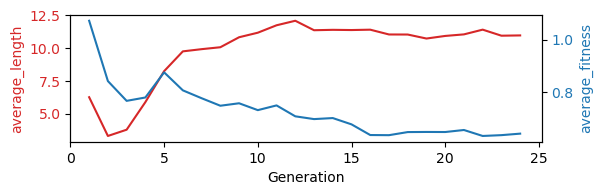

AUC:    	87
Precision: 	87
Recall: 	88
Acc (-):    	88


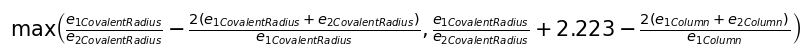

In [41]:
param_distros = {'population_size': scipy.stats.randint(500,2000),
                 'tournament_size': scipy.stats.randint(10,50),
                 'generations': scipy.stats.randint(10,50),
#                  'parsimony_coefficient': scipy.stats.uniform(0.01, 0.001)
             }
base_estimator = SymbolicClassifier(init_depth=(1,5),
                                    parsimony_coefficient=0.005,
                                    generations=25,
                                    p_crossover = 0.85,
                                    p_subtree_mutation = 0.01,
                                    p_point_mutation = 0.01,
                                    p_hoist_mutation = 0.1,
                                    const_range=(-10,10),
                                    feature_names=feature_names,
                                    # verbose=1,
                                    n_jobs=-1, 
                                    random_state=0,
                                    function_set={'add','sub','mul','div','max','min'}
                                    )

start = time.time()
sh = HalvingRandomSearchCV(base_estimator, param_distros, cv=5,
                           min_resources=20, max_resources=160, factor=2
                          ).fit(features_train, labels_train)
print(f'Time elapsed: {(time.time()-start)/3600}h')

examine_model(sh.best_estimator_)

In [43]:
sh.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3]),
 'n_resources': array([ 20,  20,  20,  20,  20,  20,  20,  20,  40,  40,  40,  40,  80,
         80, 160]),
 'mean_fit_time': array([20.06529989, 22.06564145, 14.57520509, 12.75954256, 20.98042879,
        16.48379235, 19.34976501, 22.22509418, 20.95006566, 15.87007322,
        21.1876873 , 18.7873322 , 15.3670671 , 19.8102221 , 14.88241606]),
 'std_fit_time': array([1.37552799, 0.41404109, 0.79609357, 0.6766143 , 0.3415464 ,
        1.22291016, 0.72560669, 0.46454251, 1.16791729, 0.98209438,
        1.29042023, 0.90475085, 0.35451719, 1.32734395, 0.46601646]),
 'mean_score_time': array([0.00119891, 0.00111461, 0.00109062, 0.00127931, 0.00107422,
        0.0012136 , 0.00099425, 0.00113959, 0.00103354, 0.00110846,
        0.00104375, 0.00095663, 0.00104928, 0.00110269, 0.00107174]),
 'std_score_time': array([2.59638669e-04, 4.62372251e-05, 7.77612494e-05, 2.02414728e-04,
        1.35557147e-04, 1.54995506e-04, 2.14885987e-04

In [7]:
### Plot ROC
fpr, tpr, _ = roc_curve(labels_test,predictions)
plt.figure()
plt.plot( fpr, tpr, color="darkorange", 
         label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

NameError: name 'predictions' is not defined

In [11]:
### Train a single sym learner
SR_classifier = SymbolicClassifier(population_size = 500, 
                                   generations=100,
                                   tournament_size = 10,
                                   init_depth=(1,5),
                                   parsimony_coefficient=0.005,
                                   p_crossover = 0.85,
                                   p_subtree_mutation = 0.01,
                                   p_point_mutation = 0.01,
                                   p_hoist_mutation = 0.1,
                                   const_range=(-10,10),
                                   feature_names=feature_names,
                                   n_jobs=-1, 
                                   verbose=1,
                                   random_state=1,
                                   function_set={'add','sub','mul','div','max','min'}
                                  )

SR_classifier.fit(features_train, labels_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    20.50          3.82292       19         0.547849              N/A     10.88s
   1     9.06          1.60664       19         0.533329              N/A     19.46s
   2    14.69          1.18052       21         0.507781              N/A     21.44s
   3    13.15          1.08945       31         0.497648              N/A     22.73s
   4    12.29         0.947057       13         0.466955              N/A     22.10s
   5    11.73          0.87825       13         0.466955              N/A     21.73s
   6    14.13          0.86876       17         0.458499              N/A     22.16s
   7    12.47         0.872614       13         0.466955              N/A     22.03s
   8    13.14         0.843286       13         0.458499              N/A  

SymbolicClassifier(const_range=(-10, 10),
                   feature_names=Index(['e1_CovalentRadius/e2_CovalentRadius',
       '(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius',
       '(e1_Column+e2_Column)/e1_Column'],
      dtype='object'),
                   function_set={'mul', 'max', 'div', 'min', 'add', 'sub'},
                   generations=100, init_depth=(1, 5), n_jobs=-1,
                   p_crossover=0.85, p_hoist_mutation=0.1,
                   parsimony_coefficient=0.005, population_size=250,
                   random_state=1, tournament_size=50, verbose=1)

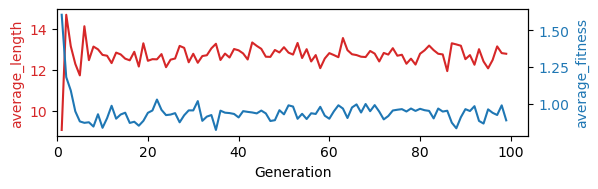

AUC:    	83
Precision: 	82
Recall: 	85
Acc (-):    	87


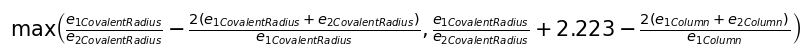

In [12]:
examine_model(SR_classifier)

In [ ]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict_proba(remainder_negative_features)[:,1]

estimated_classes[:20]

In [ ]:
def tt_split(feat_df, label_df, n_splits=5, seed):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) 
    splits = skf.split(feat_df, label_df.label_binary)
    # Use first generator output for train/test splits
    (train_idx, test_idx) = next(splits)

    # Defining train test splits using train/test indices
    features_train = features_balanced[train_idx]
    features_test =  features_balanced[test_idx]
    labels_train = labels_balanced[train_idx]
    labels_test =  labels_balanced[test_idx]
    print('Train sizes:', len(features_train), len(labels_train))
    print('Test sizes: ', len(features_test), len(labels_test)


### Train-test-split 
####################
#Generate 20-80 splits (we're going to just use one of these for the initial pass)
